In [1]:
# cd '/home/maxwell/ownCloud/v0CarND-Advanced-Lane-Lines-master'

In [2]:
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# paths 
folder_path= './camera_cal/'

In [4]:
# chess dimension (9x6)
nx = 9
ny = 6

# this is used to make work corners detection on images
nxy = [(9,5), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (5,6), (7,6), (9,6), (9,6), (9,6), (9,6)]


In [5]:
# read file location of images_for_calibration
imgNames = sorted(glob.glob( os.path.join(folder_path,'calib*.jpg') ))
#images.sort(key=str.title)

In [6]:
class CalibratorCamera:
    '''
    Used to get Camera matrix and distortion coefficients from 9x6 chessboard for project 4.
    '''
    
    
    def __init__(self, nxy, imgNames, folder_path):
        '''
        Used to initialize variables from Calibratorcamera class
        '''
        self.nxy = nxy
        self.img_names = imgNames
        self.folder_path = folder_path
                
        self.flag_find_calibration_numbers = False
    
    def find_calibration_numbers(self):
        '''
        Returns dist (distortion coeficients) and mtx (camera matrix) and save then in a pickle file.
        
        nxy: (list of tuples) vector with number of corners for each chess image. Used as input for camera calibration.
        imgNames: (list of str) list with location of all images used for camera calibration.
        folder_path_out: output folder path to save "dist" and "mtx" in a pickle file.
        '''
        
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
        
        for i, fname in enumerate(imgNames):
            nx = self.nxy[i][0]
            ny = self.nxy[i][1]
            # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
            objp = np.zeros( (nx*ny, 3), np.float32)
            objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
            # 1. Read image
            img = cv2.imread(fname)
            # 2. convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # 3. get chessboard corners and confimation flag
            ret, corners = cv2.findChessboardCorners(gray, self.nxy[i], None)
            # 4. if corners where correctly found , then append chess_corners
            if ret == True:
                
                objpoints.append(objp)
                imgpoints.append(corners)
                img = cv2.drawChessboardCorners(img, self.nxy[i], corners, ret)
            else:
                print('Error in function find_corners at image',i)
            
        img_size = (img.shape[1], img.shape[0]) # fancy way to get the first two items of shape ( in reversed order)
        
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
        self.mtx    = mtx
        self.dist   = dist
        self.flag_find_calibration_numbers = True
        
    
    def save_coefficients(self, fileName="wide_dist_pickle.p"):
        '''
        Saves the calculated camera matrix = mtx, and the coefficients = dst used on previous calibration for the camera ( find_calibration_numbers() ).
        
        fileName: (str) name for the output pickle file. Example: "wide_dist_pickle.p"
        '''
        # save coefficients and camera matrix in a pickle file
        dist_pickle = {}
        dist_pickle['mtx'] = self.mtx
        dist_pickle['dist'] = self.dist
        pickle.dump( dist_pickle, open( os.path.join(self.folder_path, fileName) , "wb" ) )
        if os.path.exists(os.path.join(self.folder_path, fileName)):
            return True
    
    def load_coefficients(self, fileName="wide_dist_pickle.p"):
        '''
        Loads the calculated camera matrix = mtx, and the coefficients = dst used on previous calibration for the camera ( find_calibration_numbers() ).
        
        fileName: (str) name for the output pickle file. Example: "wide_dist_pickle.p"
        '''
        assert os.path.exists(os.path.join(self.folder_path, fileName)) == True
        # load coefficients and camera matrix from pickle file
        dist_pickle = pickle.load( open(os.path.join(self.folder_path, fileName), "rb"))
        self.mtx = dist_pickle['mtx']
        self.dist= dist_pickle['dist']
        return True
    
    def get_coefficients(self, doFlag=False, getValuesFlag=True):
        '''
        Gets radial undistorted images
        
        self.nxy: (list of tuples) vector with number of corners for each chess image. Used as input for camera calibration.
        self.imgNames: (list of str) list with location of all images used for camera calibration.
        doflag: (Bool) to specifies if coefficients are calculated or loaded from pickle data
        getValuesFlag: (Bool) to espcify if you want to inmediately retrieve "mtx" and "dist" values
        '''
        if (doFlag == False):
            self.load_coefficients()
        else:
            self.find_calibration_numbers()
        if (getValuesFlag ==True):
            return self.mtx, self.dist
    
    def get_undistorted(self, img):
        '''
        Gets undistorted images
    
        img: input image to correct radial distortion
        self.flag_find_calibration_numbers: (Bool). Flag from the method find_calibration_numbers() used in here to choose if used calculatd values from pickle file or re-calculate-them
        self.mtx:  matrix corection. Used for correction
        self.dist: coefficients used for correction
        '''
        condition = (self.find_calibration_numbers == False)
        if condition:
            self.find_calibration_numbers()
        
        undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undistorted

In [7]:
def draw_corners(nxy, images):
    '''
    Returns an aray of images with detected corners plottled.
    
    nxy: (list of tuples) vector with number of corners for each chess image. Used as input for camera calibration.
    images: (list of str) list with location of all images used for camera calibration.
    '''
    import cv2
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    imgsCorners = []
    for i, fname in enumerate(images):
        #print(i, fname)
        nx = nxy[i][0]
        ny = nxy[i][1]
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros( (nx*ny, 3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, nxy[i], None)
        
        # correction in the corrdinate of the first corner found for 9th image :
        #if i == 8:
        #    corners[0] = [402.0, 298.0]
        
        # if corners where correctly found , then append chess_corners
        if ret == True:
            
            objpoints.append(objp)
            imgpoints.append(corners)
            
            cv2.drawChessboardCorners(img, nxy[i], corners, ret)
            imgsCorners.append(img)
        else:
            print('Error in function draw_corners at image',i)
    
    return imgsCorners


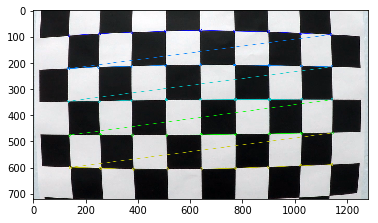

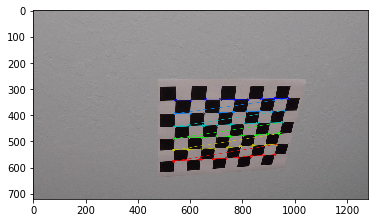

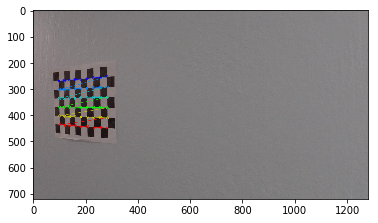

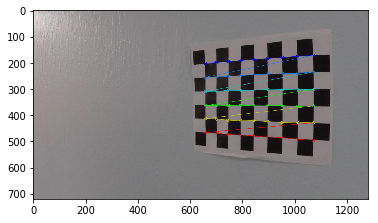

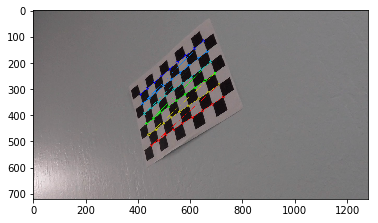

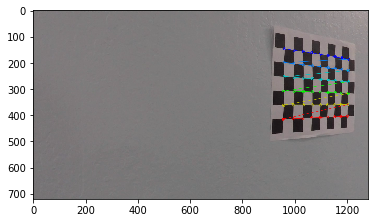

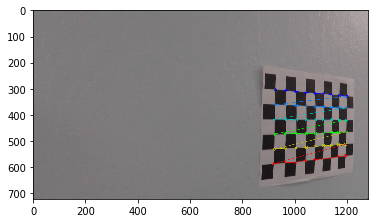

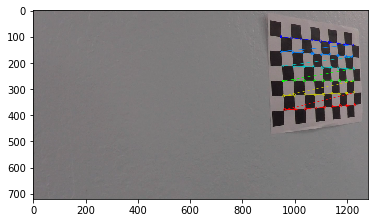

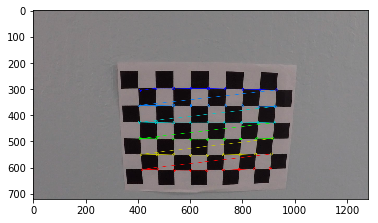

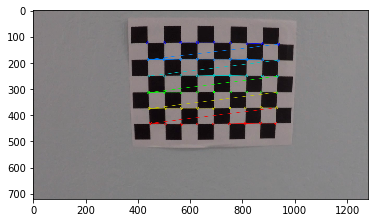

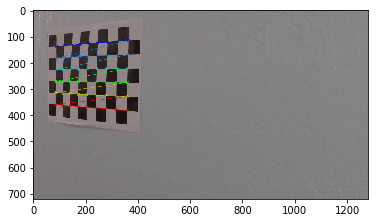

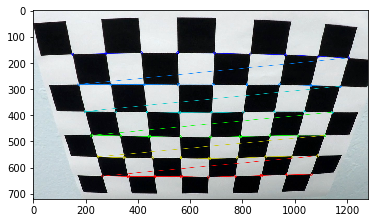

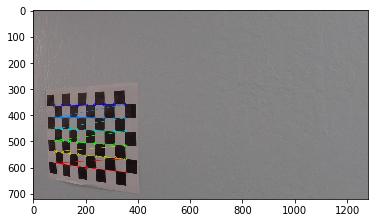

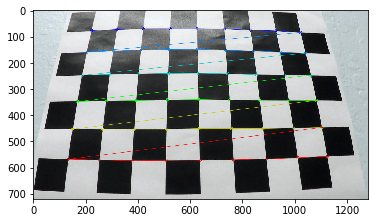

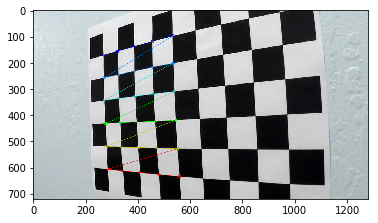

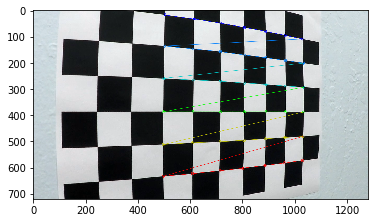

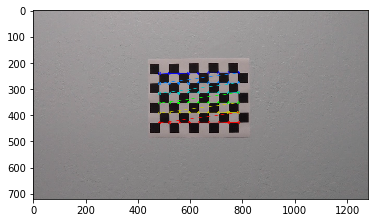

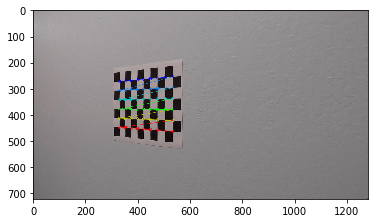

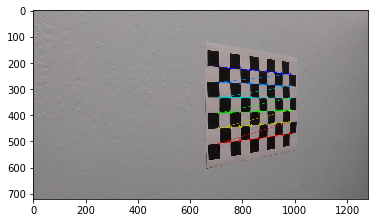

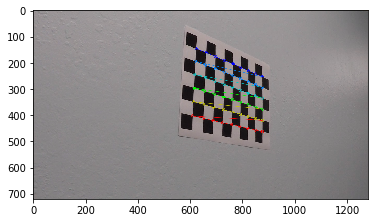

In [8]:
img_corners = []
for i,img_name in enumerate(imgNames):
    a = draw_corners(nxy=nxy, images=imgNames)
    plt.figure()
    plt.imshow(a[i])
    img_corners.append(a[i])

In [9]:
def show_images(imgs, tdelay= 1000):
    '''
    Iterator to Show in cv2 the lsit of images given
    imgs: (list of npuin8) list of images to display
    tdelay: (int) time to delay (in miliseconds) between images
    '''
    for i in range(len(imgs)):
        cv2.namedWindow('resized_window', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('resized_window', 600, 600)
        cv2.imshow('resized_window', imgs[i])
        cv2.waitKey(tdelay)
    cv2.waitKey(2*tdelay)
    cv2.destroyAllWindows()

In [10]:
# Part 1 Camera calibration. Get calibration coefficients and save them in a pickle file
# create an instance to calibrate camera, and give nx and ny for each image.
# include input image names for camera calibration.
# included as an argument camera_cal folder path
w = CalibratorCamera(nxy=nxy,imgNames=imgNames, folder_path=folder_path )
# Do camera calibration and return camera matrix and distrotion coefficients. (ret, mtx, dist, rvecs, tvecs )
w.find_calibration_numbers()
# save coefficients in a pickle file to use them for calibration in the car project lane detection.
# Note: this pickle file is saevd in the same folder: camera_cal with the chess images provided to calibrate camera
w.save_coefficients(fileName='wide_dist_pickle.p')

True

In [11]:
# Part 2 Camera calibration. upload camera matrix and distortion coefficients.
# apply distortion correction to chess images.

w2 = CalibratorCamera(nxy=nxy,imgNames=imgNames, folder_path=folder_path )
w2.load_coefficients(fileName='wide_dist_pickle.p')

True

In [12]:
# plot original and udistorted images
original = []
undistorted = []
for i,img_name in enumerate(imgNames):
    in_img = mpimg.imread(img_name)
    out_img = w2.get_undistorted(in_img)
    
    original.append( in_img )
    undistorted.append( out_img )

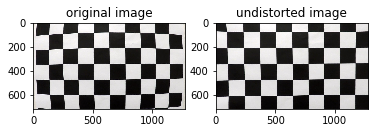

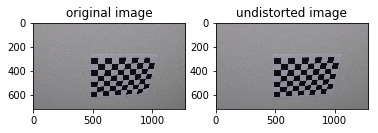

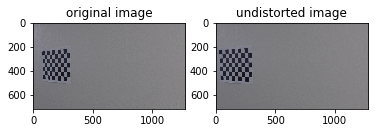

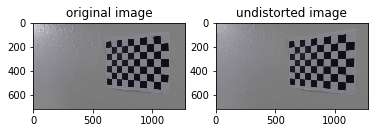

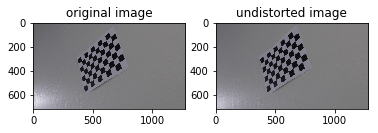

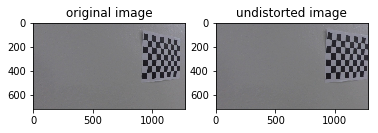

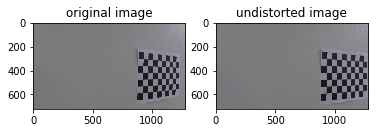

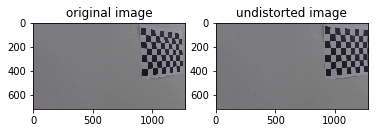

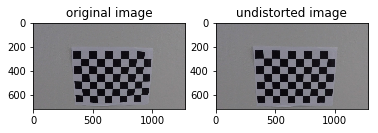

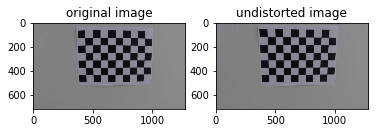

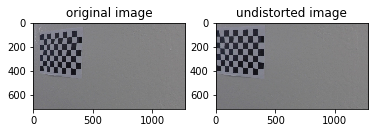

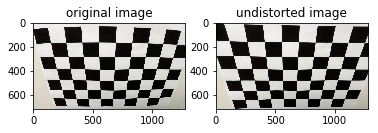

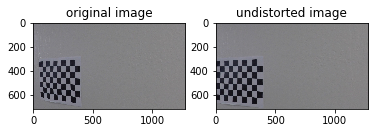

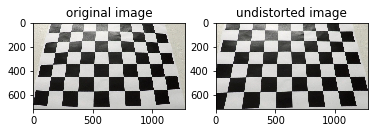

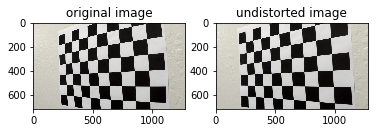

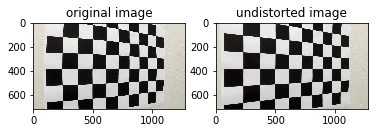

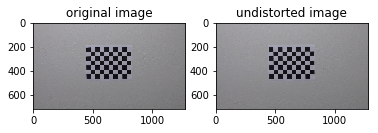

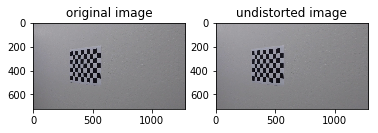

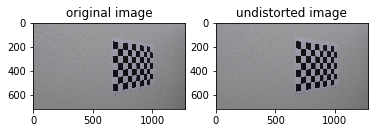

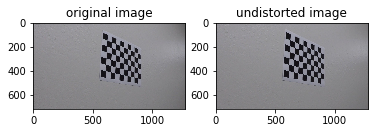

In [13]:
for i,img_name in enumerate(imgNames):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(original[i])
    plt.title('original image')
    plt.subplot(1,2,2)
    plt.imshow(undistorted[i])
    plt.title('undistorted image')
    plt.pause(1)
    

In [15]:
# import libraries
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.signal import find_peaks_cwt

# import custom functions
from camera_calibration_final import CalibratorCamera, draw_corners, show_images


In [16]:
# paths
folder_path= './camera_cal/'
folder_path2= './test_images/'

In [17]:
# chess board dimensions (9x6 inner corners)
nx = 9
ny = 6
# used to make work corners detection on images
nxy = [(9,5), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (9,6), (5,6), (7,6), (9,6), (9,6), (9,6), (9,6)]


In [18]:
# read  location of images_for_calibration
imgNames = sorted(glob.glob( os.path.join(folder_path,'calib*.jpg') ))
imgNames2 = sorted(glob.glob( os.path.join(folder_path2,'*.jpg') ))


In [19]:

# get camera matrix and distorsion coefficients
mtx, dist = CalibratorCamera(nxy=nxy, imgNames=imgNames, folder_path=folder_path).get_coefficients()


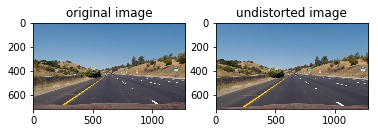

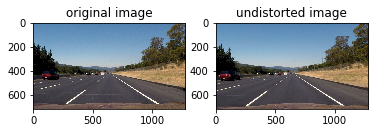

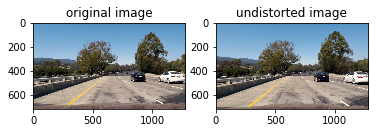

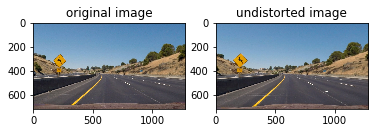

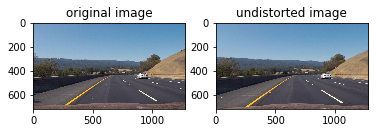

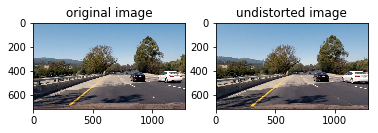

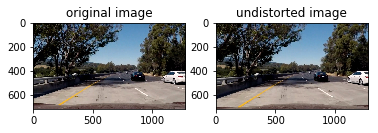

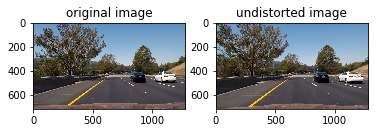

In [23]:
# 1.  undistort test images
def process_rdistortion(img):
    '''
    Returns images after radial distortion correction
    
    img: (npuint8) input image to correct radial distorsion
    '''
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted


# plot undistorted images
imgs1 = []
imgs2 = []
for i, fname in enumerate(imgNames2):
    a = mpimg.imread(imgNames2[i])
    b = process_rdistortion(a)
    imgs1.append(a)
    imgs2.append(b)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.title('original image')
    plt.subplot(1,2,2)
    plt.imshow(b)
    plt.title('undistorted image')

In [26]:
# 2. blur images
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


In [27]:
# 3.  HSL color space yellow white-mask
def hls_wyMask(img):
    '''
    This functions returns a copy of the input image after aplying white and yellow masks in HSL space.
    
    '''
    #image in RGB space
    imgRGB = np.copy(img)
    #image in HSL space
    imgHSL = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
    # Yellow Mask
    lowerYellow= np.array([ 10, 0, 100], dtype=np.uint8)
    upperYellow= np.array([40,255,255], dtype=np.uint8)
    yellowMask= cv2.inRange(imgHSL, lowerYellow, upperYellow)
    # White Mask
    lowerWhite= np.array([ 0, 200, 0], dtype=np.uint8)
    upperWhite= np.array([255,255,255], dtype=np.uint8)
    whiteMask= cv2.inRange(imgHSL, lowerWhite, upperWhite)
    
    # Yellow or White colors passes
    ywMask1 = cv2.bitwise_or(yellowMask, whiteMask)
    # Bitwise-AND  (hls_image) and (Yellow-White mask)
    ywMaskout = cv2.bitwise_and(imgRGB, imgRGB, mask = ywMask1)

    return ywMaskout

In [28]:
# 4.  HSV color space yellow white-mask
def hsv_wyMask(img):
    '''
    This functions returns a copy of the input image after aplying white and yellow masks in HSV space.
    
    '''
    #image in RGB space
    imgRGB = np.copy(img)
    #image in HSL space
    imgHSV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    # Yellow Mask
    lowerYellow= np.array([ 0, 100, 100], dtype=np.uint8)
    upperYellow= np.array([190,250,255], dtype=np.uint8)
    yellowMask= cv2.inRange(imgHSV, lowerYellow, upperYellow)
    # White Mask
    lowerWhite= np.array([ 200, 200, 200], dtype=np.uint8)
    upperWhite= np.array([255,255,255], dtype=np.uint8)
    whiteMask= cv2.inRange(imgRGB, lowerWhite, upperWhite)
    
    # Yellow or White colors passes
    ywMask1 = cv2.bitwise_or(yellowMask, whiteMask)
    
    return ywMask1


In [29]:
# 5. Convert input images to gray scale and return a binary iamge
def gray_binary(imgx, thresh_min= 130, thresh_max= 255):
    '''
    returns thresholded imaged in grayscale
    '''
    img = np.copy(imgx)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_binary = np.zeros_like(gray)
    gray_binary[ (gray >thresh_min) & (gray < thresh_max) ] = 1
    
    return gray_binary

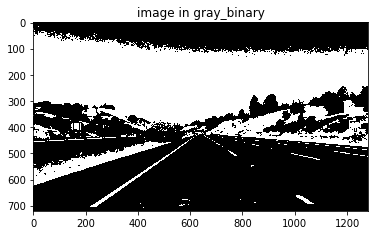

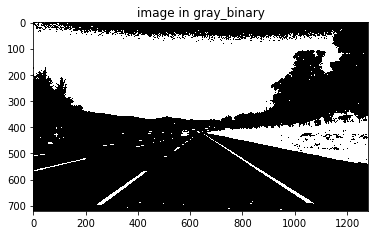

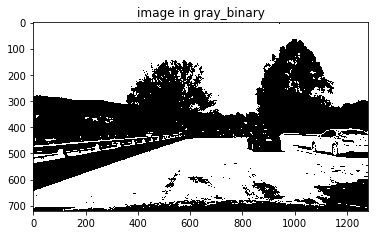

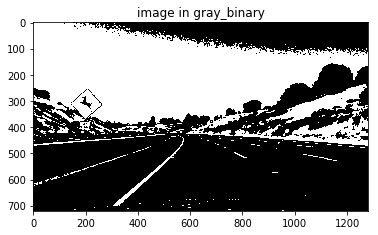

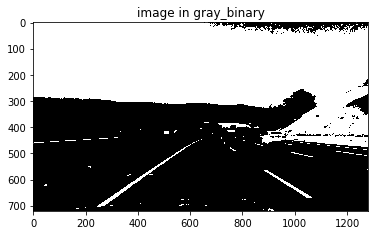

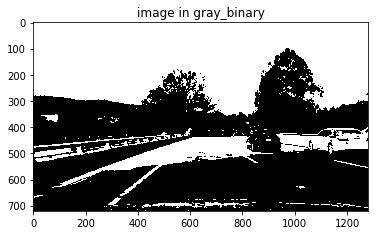

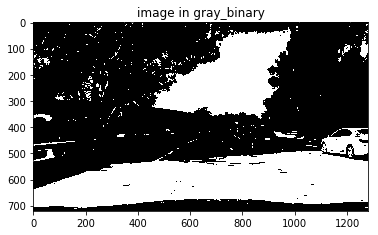

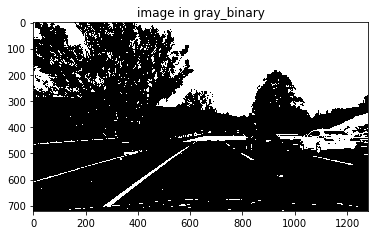

In [30]:
for i in range(8):
    plt.title('image in gray_binary')
    plt.imshow(gray_binary(imgs2[i]), cmap='gray')
    plt.pause(1)

In [31]:
# 6. Convert S channel or L channel into binary iamge (from iamge in HSL color space)
def hls_channel_binary(imgx, select='s',thresh_min= 170, thresh_max= 255):
    '''
    returns thresholded image from the l or s channel of image in HLS
    '''
    img = np.copy(imgx)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l = hls[:,:,2]
    s = hls[:,:,2]
    
    binary = np.zeros_like(s)
    if (select == 's'):
        binary[ (s > thresh_min) & (s < thresh_max) ] = 1
    elif (select == 'l'):
        binary[ (l > thresh_min) & (l < thresh_max) ] = 1
    
    return binary

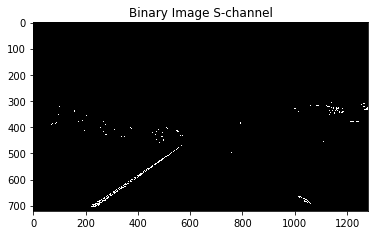

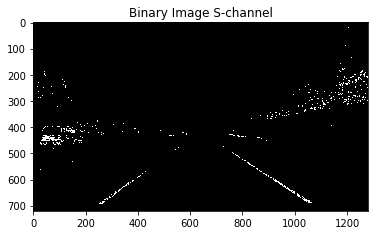

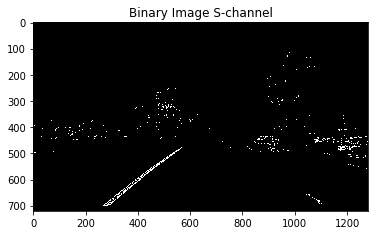

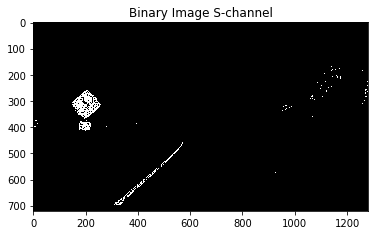

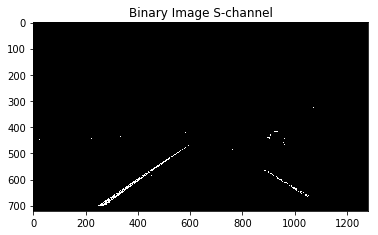

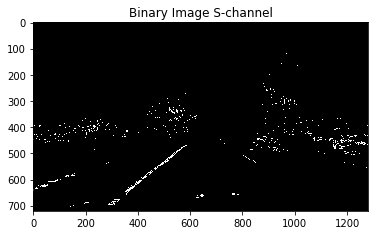

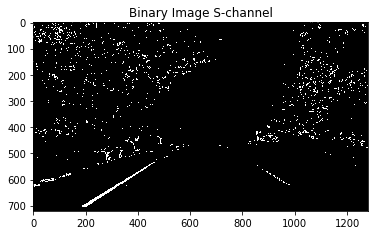

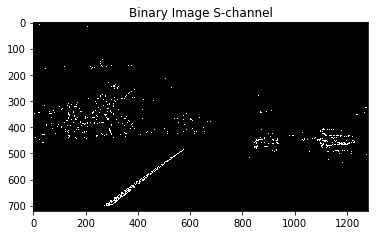

In [71]:
# plot s_channel binary images

for i, fname in enumerate(imgNames2):
    c = hls_channel_binary(imgs2[i], select='s',thresh_min= 170, thresh_max= 255)
    
    plt.title('Binary Image S-channel')
    plt.imshow(c, cmap='gray')
    plt.pause(1)


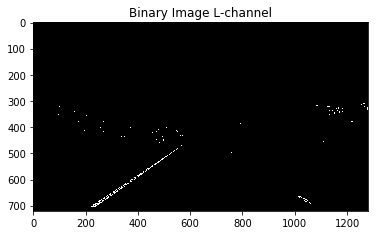

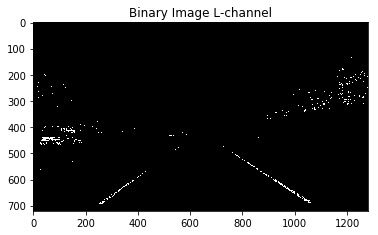

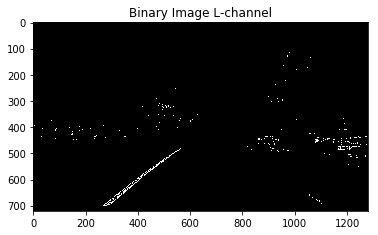

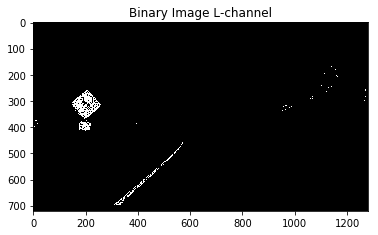

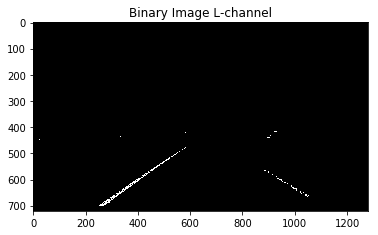

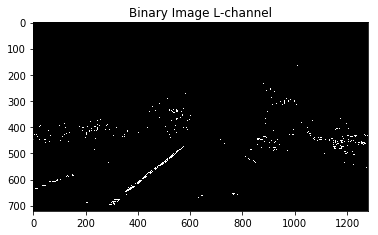

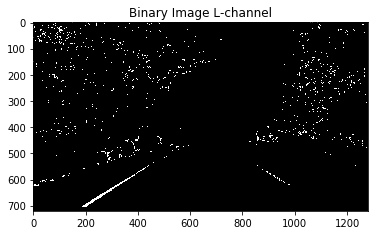

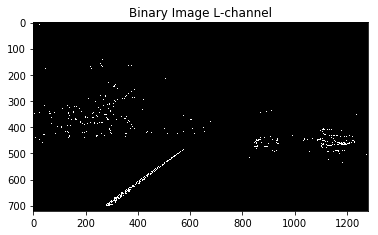

In [72]:
# plot l_channel binary images

for i, fname in enumerate(imgNames2):
    c = hls_channel_binary(imgs2[i], select='l',thresh_min= 190, thresh_max= 255)
    
    plt.title('Binary Image L-channel')
    plt.imshow(c, cmap='gray')
    plt.pause(1)

In [32]:
# 7. Apply gradients in x direction or in y direction (inspired on class notes)
def abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh=(20, 200)):
    
    import cv2
    import numpy as np
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    else:
        return print('error')
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8( 255*(abs_sobel/np.max(abs_sobel)) )
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary [ (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    grad_binary = sbinary
    return grad_binary

In [33]:
# 8. Apply magnitude threshold (inspired on class notes)
def mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 180)):
    import cv2
    import numpy as np
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobel = np.absolute(sobelMag)
    scaled_sobel = np.uint8( 255*(abs_sobel/np.max(abs_sobel)) )
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary [ (scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    mag_binary = sbinary
    return mag_binary

In [34]:
# 9. Apply directional threshold (inspired on class notes)
def dir_threshold(img, sobel_kernel=3, thresh=(0.8,1.1) ): # thresh=(0, np.pi/2)
    import cv2
    import numpy as np
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan2_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(arctan2_sobel)
    sbinary[ (arctan2_sobel > thresh[0]) & (arctan2_sobel < thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    dir_binary = sbinary
    return dir_binary

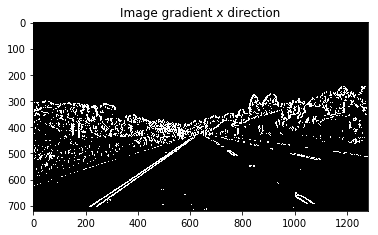

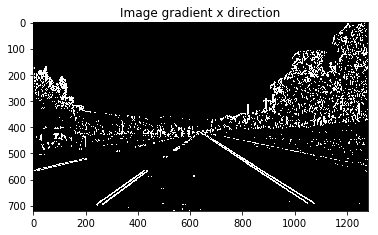

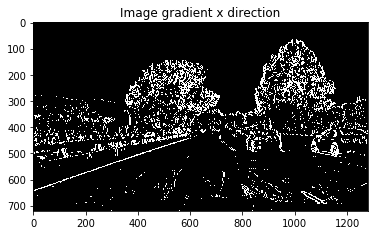

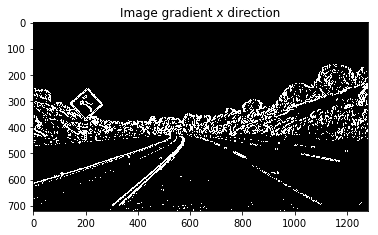

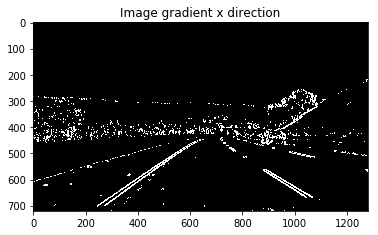

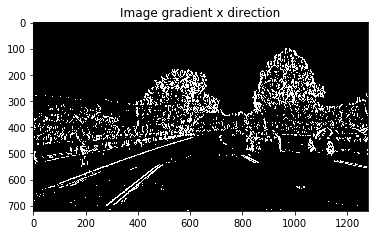

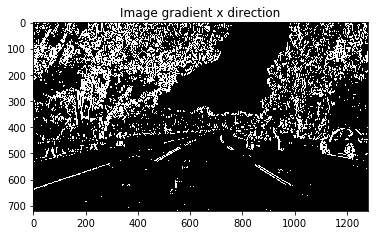

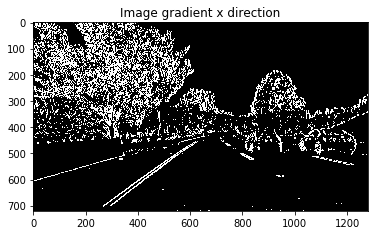

In [35]:
# plot some binary images
for i in range(8):
    imgsx = abs_sobel_thresh( imgs2[i], orient='x', sobel_kernel=9, thresh=(20,200) )
    plt.title('Image gradient x direction')
    plt.imshow(imgsx, cmap='gray')
    plt.pause(1)


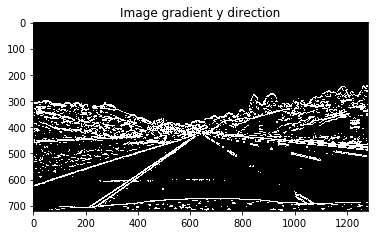

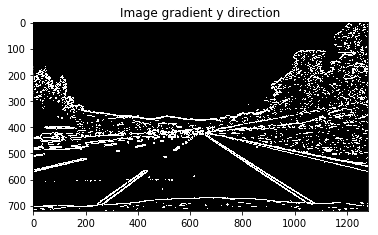

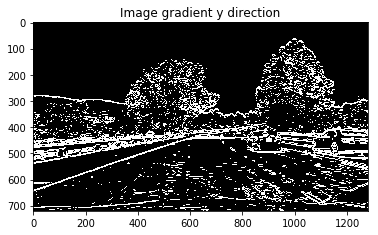

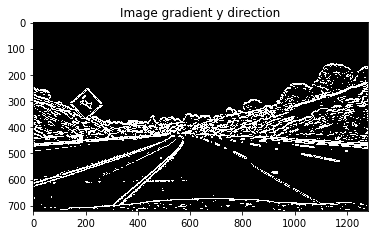

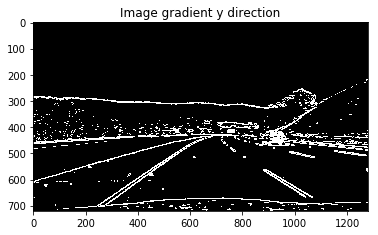

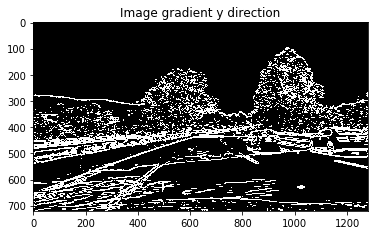

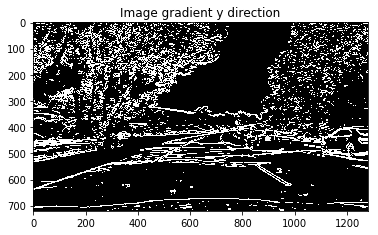

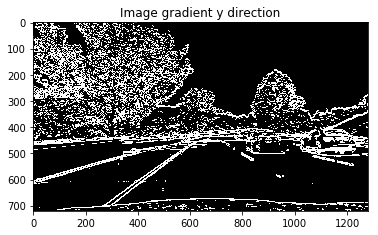

In [73]:
# plot some binary images y direction
for i in range(8):
    imgsx = abs_sobel_thresh( imgs2[i], orient='y', sobel_kernel=9, thresh=(20,200) )
    plt.title('Image gradient y direction')
    plt.imshow(imgsx, cmap='gray')
    plt.pause(1)

In [37]:
# 10. get binary threshold image combineing all binary images.
def binary_threshold(imgx):
    '''
    Returns a combined binary image after applying thresholds to s_channel, l_channel, gray_binary image,  and HSV white_yellow mask
    '''
    
    img = np.copy(imgx)
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    gray = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) )
    #gray = gaussian_blur(gray, 7)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # binary after applying Sobel x
    gradx_binary = abs_sobel_thresh( img, orient='x', sobel_kernel=9, thresh=(20,200) )
    
    # binary of thresholded S and L channel of image in HSL color space
    s_binary = hls_channel_binary(img, select='s', thresh_min=170, thresh_max=255)
    l_binary = hls_channel_binary(img, select='l', thresh_min=190, thresh_max=255)
    
    # binary of grayscale image
    g_binary = gray_binary(img)
    
    # image after applying: hsv yellow and white color mask image
    hsvcolorselection = hsv_wyMask(img)
    
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(s_channel)
    combined_binary[ (hsvcolorselection == 255) | ((s_binary ==1) & (l_binary == 1)) | ( (gradx_binary == 1) & (g_binary == 1) ) | (l_binary == 1) ] = 1
    
    return combined_binary

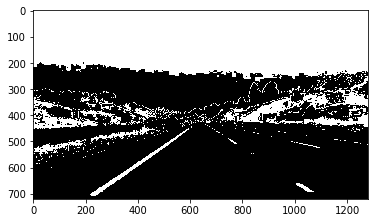

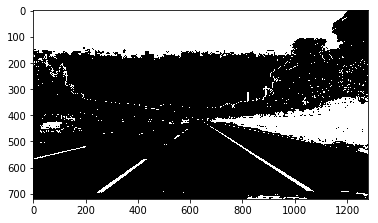

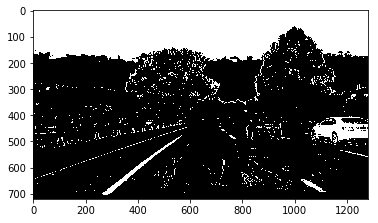

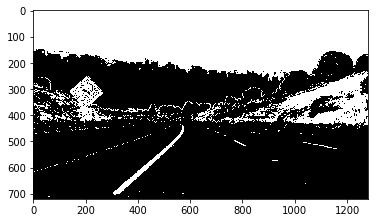

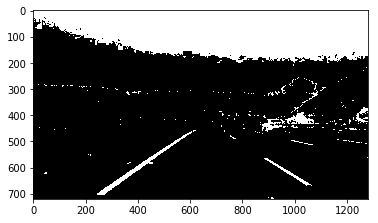

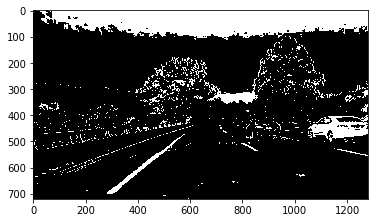

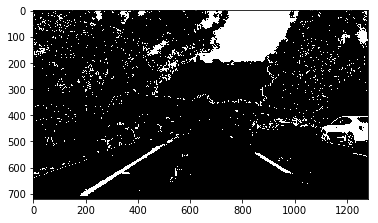

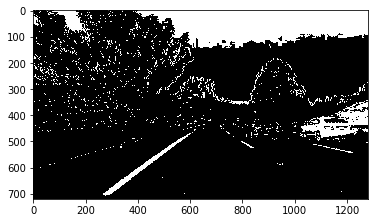

In [38]:
for i in range (8):
    plt.imshow(binary_threshold(imgs2[i]), cmap='gray')
    plt.pause(1)

In [40]:
# 11. define vertices to use to generate region fo interest
def generate_vertices(img):

    #h,w,d= img.shape  # this line is for width x heigh x depht images
    h,w= img.shape[0:2]     # this line is for width x heigh images
    
    out_downLeft = [0.1*w, 1.0*h]
    out_upLeft   = [0.4*w, 0.5*h]
    out_upRigth  = [0.6*w, 0.5*h]
    out_downRigth= [0.95*w, 1.0*h]
    
    in_downRigth=  [0.6*w, 0.96*h]
    in_upRigth  =  [0.52*w, 0.6*h]
    in_upLeft   =  [0.48*w, 0.6*h]
    in_downLeft =  [0.4*w, 0.96*h]
    
    #vertices= np.array([[ out_downLeft, out_upLeft, out_upRigth, out_downRigth, in_downRigth, in_upRigth, in_upLeft, in_downLeft ]], dtype= np.int32)
    vertices= np.array([[ out_downLeft, out_upLeft, out_upRigth, out_downRigth ]], dtype= np.int32)
    return vertices

In [41]:
# 12. generate region fo interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a zeros-mask to start with
    mask = np.zeros_like(img)   
    
            
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(np.copy(img), mask)
    
    # uncomment this line to return masked iamge with plottled region
    #masked_image = cv2.bitwise_or(masked_image, cv2.polylines(masked_image, vertices, False, 255) )
    return masked_image


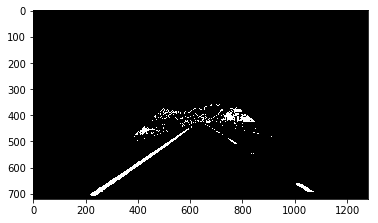

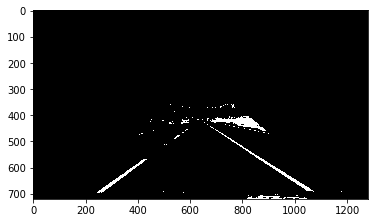

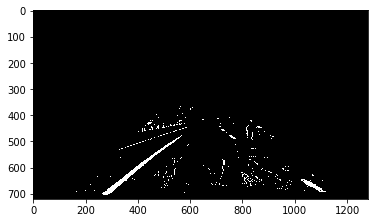

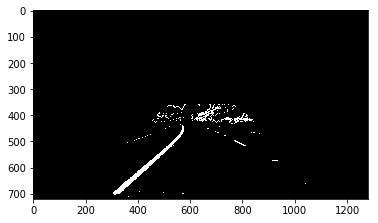

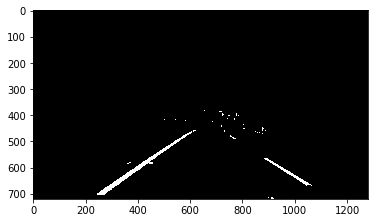

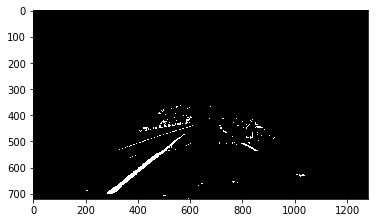

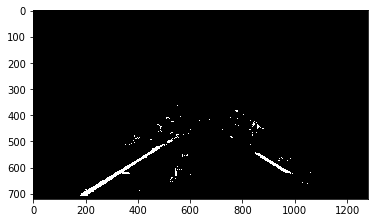

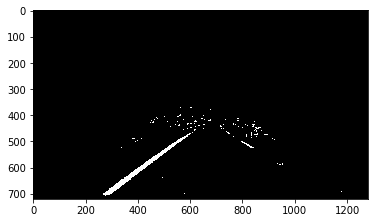

In [42]:
# plot binary region of interest
roiImgs = []
for i in range (8):
    binaryimgx = binary_threshold(imgs2[i])
    vx = generate_vertices(binaryimgx)
    bin_roix= region_of_interest(np.copy(binaryimgx), vx)
    roiImgs.append( bin_roix )
    plt.imshow(bin_roix, cmap='gray')
    plt.pause(1)

In [43]:
# 13. Define hough transform parametrs


rho=1
theta= 1*np.pi/180
threshold=30
min_line_len= 1
max_line_gap= 10

kermelsize = 9
canny_thersholdl = 40
canny_thersholdh = 150

In [44]:
# 14. calculate line slope

In [45]:
# 14.1 calculate line slope
def calc_slope(oneline):
    '''
    Returns cartesian slope
    m = (y2-y1) / (x2 -x1)
    '''
    x1 = oneline[0][0]
    y1 = oneline[0][1]
    x2 = oneline[0][2]
    y2 = oneline[0][3]
    
    m = (y2 -y1)/(x2 -x1)
    return m

In [46]:
#  14.2 getline coordinate points
def get_line(lines, ymin, ymax):
    '''
    Computes average slope and intercept with y coordinate
    Returns coordiantes for a line
    '''
    
    general_slope = 0
    general_intercept = 0
    nlines = len(lines)
    
    
    for oneline in lines:
        for x1,y1,x2,y2 in oneline:
            slope = (y2 -y1) / (x2 - x1)
            general_slope = general_slope + slope
            general_intercept = general_intercept + ( y1 - slope * x1)
        
    averaged_slope = general_slope/nlines
    averaged_intercept_y_coordinate = general_intercept/nlines
    
    x1 = ( ymin - averaged_intercept_y_coordinate )/averaged_slope
    x2 = ( ymax - averaged_intercept_y_coordinate )/averaged_slope
    
    return (int(x1), ymin, int(x2), ymax)

In [47]:
# 15.1 draw line
def draw_line(imgx, line, color=[255,0,0], thickness=2):
    '''
    Draws a line on a copy of the input image
    '''
    #img = np.copy(imgx)
    x1,y1,x2,y2 = line
    cv2.line(imgx, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)

In [48]:
# 15.2 define function to draw lines
def draw_lines2(imgx, lines, color=[255,0,0], thickness=2):
    '''
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    '''
    img = imgx
    imgh = img.shape[0]
    imgw = img.shape[1]
    
    ymin = int( imgh*0.7)
    ymax = int(imgh)
    
    pos_slopes = list(filter(lambda oneline:  (calc_slope( oneline) > 0.5) and (calc_slope( oneline) < 0.9) , lines))
    neg_slopes = list(filter(lambda oneline:  (calc_slope( oneline) < -0.5) and (calc_slope( oneline) > -0.9) , lines))

    line_1 = None
    line_2 = None
    
    lp = len(pos_slopes)
    ln = len(neg_slopes)
    
    if (ln > 0):
        line_2 = get_line(neg_slopes, ymin=ymin, ymax= ymax)
        draw_line(imgx, line_2, color=color, thickness=thickness)
        
    if (lp > 0):
        line_1 = get_line(pos_slopes, ymin=ymin, ymax= ymax)
        draw_line(imgx, line_1, color=color, thickness=thickness)
        
    answ = [None, None]
    if line_1:
        answ[0] = line_1
    else:
        return None
    
    if line_2:
        answ[1] = line_2
    else:
        return None
    
    return answ

In [49]:
# 16. Apply hough transform
def hough_lines(imgx, rho=1, theta= np.pi/180, threshold=30, min_line_len=1, max_line_gap=10):
    """
    Returns an image with hough lines drawn.
    
    Imgx: Image after applying canny edge detection.
        
    
    """
    img = np.copy(imgx)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines2 = draw_lines2(line_img, lines, thickness=6)
    return lines2, line_img

In [50]:
# 17. Generate transparency on image
def addweighted_image(imgx, imgy, alpha= 0.8, beta=1.0, l = 0.0):
    '''
    Computes cv2.addWeighted( imgx, alpha, imgy, beta, l)
    
    imgx: inpunt image
    imgy: output image
    '''
    img_original = imgx
    img_output = imgy
    
    weighted = cv2.addWeighted(img_original, alpha, img_output, beta, l)
    return weighted

0


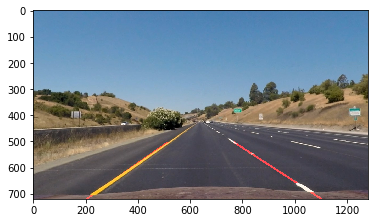

1


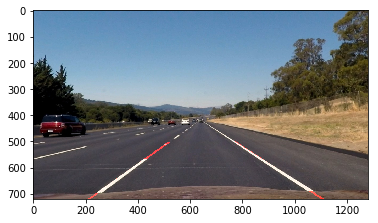

/usr/local/anaconda/anaconda3/envs/clone_tfp36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in int_scalars
  if sys.path[0] == '':


2


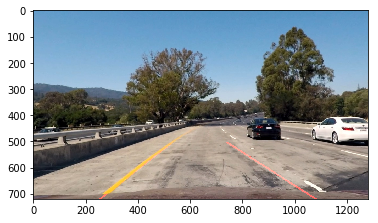

3


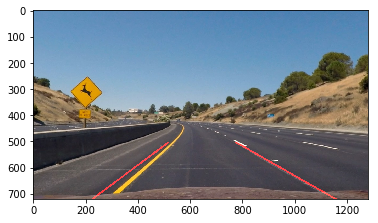

4


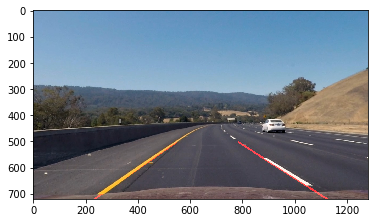

5


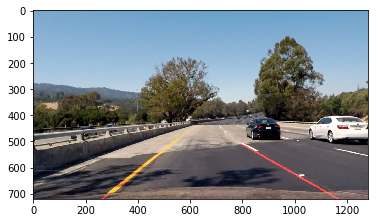

6


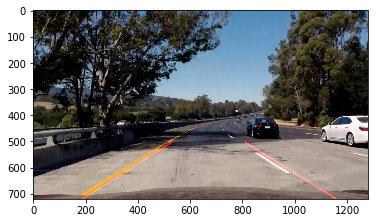

7


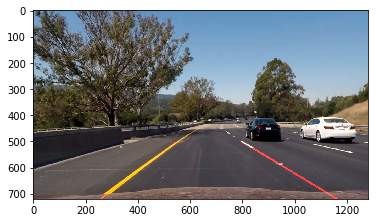

In [51]:
# plot lane lines in original iamges
for i in range(8):
    lines_pn, linesimg = hough_lines(roiImgs[i], rho= rho, theta= theta, threshold= threshold, min_line_len= min_line_len, max_line_gap= max_line_gap)
    lane_lines_img= addweighted_image(linesimg, imgs2[i])
    plt.imshow(lane_lines_img)
    print(i)
    plt.pause(1)

In [52]:
# 18. compute again camera matrix
def compute_tf_matrix(imgx, hough_lines):
    """
    Gets M and minv to for perspective transform ( birds eye)
    Parameters: 
        imgx: image with hough lines drawn in it.
        hough_lines: Coordinates of the left and rigth lane lines after (hough tranformation)
    
    """
    img = imgx
    imghigh = img.shape[0]
    imgwidth= img.shape[1]
    
    if not hough_lines: return None, img
    
    # choosing output high of points after tranformation
    ylimit = 0.4 * imghigh
    # get previously calculated(averaged) hough lines
    line1, line2 = hough_lines
    
 
    # get oringinal and destination points based on previously calculated hough lines
    # top righ, bottom rigth, top left, bottom left
    trs     = [line1[0], line1[1]]
    brs     = [line1[2], line1[3]]
    tls     = [line2[0], line2[1]]
    bls     = [line2[2], line2[3]]
    
    trd     = [line1[2], ylimit] 
    brd     = [line1[2], line1[3]]
    tld     = [line2[2], ylimit]
    bld     = [line2[2], line2[3]]
    
    
    source_img_pts = [trs, brs, tls, bls]
    destination_pts= [trd, brd, tld, bld]
    
    # defining calibration box in source and destination(warped/wanted) images
    #img_shape = (imgwidth, imghigh)
    
    # source points np.float
    src = np.float32(source_img_pts)
    # destiantion points np.float
    dst = np.float32(destination_pts)
    
    # direct transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    return (M, Minv)

In [53]:
####### IMPORTANT hough_lines is over ROI image and tf matrix uses those lines_pn and undistorted iamge

# get  matrix transforms
mtrans = []
mtransinv = []
for i in range(8):
    #print(i)
    lines_pn, linesimg = hough_lines(roiImgs[i], rho= rho, theta= theta, threshold= threshold, min_line_len= min_line_len, max_line_gap= max_line_gap)  
    mx, mxinv = compute_tf_matrix(imgs2[i], hough_lines=lines_pn)
    mtrans.append(mx)
    mtransinv.append(mxinv)

/usr/local/anaconda/anaconda3/envs/clone_tfp36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in int_scalars
  if sys.path[0] == '':


In [54]:
#  19. Pipeline to get camera matrix transforms
def pipeline_get_tf_matrix(imgx):
    """
    Find hoguh lines, and then get M and Minv to get birds eye. (top view for lane lines)
    
    Parameters:
        imgx -- image with lane lines . (most of times straigh lines)
    """
    img = np.copy(imgx)
    
    img = process_rdistortion(img)
    
    binary_img = binary_threshold(img)
    
    vertices_img = generate_vertices(img)
    roi_img = region_of_interest(binary_img, vertices_img )
    
    lines, lines_img = hough_lines(roi_img, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_len, max_line_gap=max_line_gap)
    
    M, M_inv = compute_tf_matrix(img, lines)
        
    return (M, M_inv)

In [55]:
# 20. Apply perspective transformations to image
def transform_perspective(img, M):
    '''
    Applies perpective transformation to image (bird eye)
    '''
    imgw = img.shape[1]
    imgh = img.shape[0]
    return cv2.warpPerspective(img, M, (imgw, imgh), flags=cv2.INTER_LINEAR)


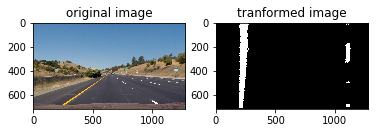

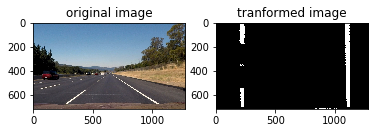

/usr/local/anaconda/anaconda3/envs/clone_tfp36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in int_scalars
  if sys.path[0] == '':


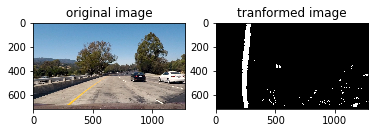

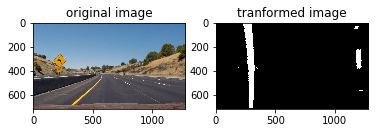

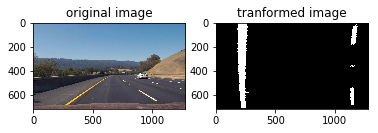

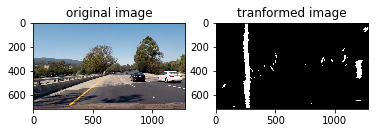

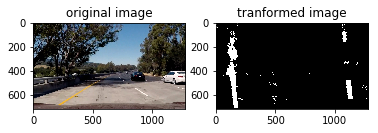

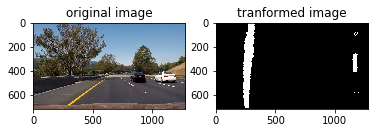

In [56]:
# get  camera matrix transforms
# NOTE: pipeline is applied for distorted inages
# But, transfor_perspective is applied to roi images
mtrans2 = []
mtransinv2 = []
birdbinary = []
for i in range(8):
    #print(i)
    mx2, mx2inv = pipeline_get_tf_matrix(imgs1[i])
    birdx = transform_perspective(roiImgs[i], mx2)
    
    mtrans2.append( mx2)    
    mtransinv.append(mx2inv)
    birdbinary.append(birdx)
    
    plt.subplot(1,2,1)
    plt.imshow(imgs1[i])
    plt.title('original image')
    
    plt.subplot(1,2,2)
    plt.imshow(birdx, cmap='gray')
    plt.title('tranformed image')
    plt.pause(1)

In [57]:
# 21.  Get the detected lane lines base   
def getlanelinesbase(imgx):
    '''
    Returns lane (left, rigth) lines
    imgx: Input image bird eye binary therhold
    '''
    img = imgx
    imghalf = int(img.shape[0]*0.5)
    imglength= img.shape[0]
    
    hist = np.sum( img[imghalf:,:], axis=0 )
    indexvec= find_peaks_cwt(hist, np.arange(1,550))
    
    indexl= indexvec[0]
    indexr= indexvec[-1]
    
    lanebase = [(indexl, imglength), (indexr, imglength)]
    return lanebase

In [59]:
# get left and rigth lane lines
leftbase = []
rigthbase= []
for i in range(8):
    #print(i)
    leftbasex, rigthbasex = getlanelinesbase(birdx)
    leftbase.append(leftbasex)
    rigthbase.append(rigthbasex)

/usr/local/anaconda/anaconda3/envs/clone_tfp36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


In [60]:
# 22. get pixels positions for lane lines
def getlanepixels(imgx, lanebase):
    '''
    Gets pixels positions/index on the lane lines using a window of 120 pixels.
        
    imgx: bird eye binary image
    lanebase: lanelines output postion (x,y) from the  getlanelinesbase(imgx) function
    '''
    
    windowsize = 120 * 2
    
    xbase = lanebase[0]
    
    if(xbase > windowsize):
        windowlow = int ( xbase - windowsize/2 )
    else:
        windowlow = 0
        
    windowhigh = int ( xbase + windowsize/2) 
    
    # Define a region
    window = imgx[:, int( windowlow) : int( windowhigh) ]

    # Find the coordinates of the white pixels in this region
    x, y = np.where(window == 1)
    
    # Add window low as an offset
    y += np.uint64(windowlow)
    
    coordinates = (x,y)
    return coordinates

In [61]:

# 23. get polinomial 2nd order fitted for xi, yi point collection
def getcurvedlaneline(pixels):
    '''
    Returns a seccond order polifit for given x_index, y_index points
    '''
    xp, yp = pixels
    order = 2
    polifit = np.polyfit(xp, yp, deg=order)
    return polifit

In [62]:

# 24. draw the curved line
def drawcurvedline(imgx, poliline):
    '''
    imgx: original image (to draw line)
    poliline: coefficients of 2nd order polinomial line
    '''
    imgy= imgx.shape[0]
    
    poli = np.poly1d(poliline)
    xp = list(range(0, imgy))
    yp = list(map(int, poli(xp)))
    points = np.array([[_y,_x] for _x, _y in zip(xp, yp)])
    
    pointts = points.reshape((-1,1,2))
    
    cv2.polylines(imgx, np.int32([pointts]), False, color=(255,0,0), thickness=40)
    return pointts

In [63]:


# 25. estiamte curvature radius
def calculatercurvature(imgx, lanepixels):
    '''
    Estimates the curvature radius for lane line
    
    imgx: input image
    lanepixels: (xpixels, ypixels) from the lane line
    '''
    imghigh = imgx.shape[1]
    yp, xp = lanepixels
    
    
    # Define conversions in x and y from pixels space to meters
    # Convert from pixels to meters (xp to xmbypixel and yp to ymbypixel )
    ymbypixel = 30/imghigh # aprox meters by pixel
    xmbypixel = 3.7/700 # aprox meters by pixel
    
    yeval = np.max(yp)

    polifit = np.polyfit(yp*ymbypixel, xp*xmbypixel, 2)
    
    estimation= int(((1 + (2*polifit[0]*yeval + polifit[1])**2)**1.5)/np.absolute(2*polifit[0]))
    return estimation


In [64]:

# 26. Estimate distance from lane

def estimatedistancefromlane(imgx, leftbase, rightbase):
    '''
    Estimates the distance of the car from the center of the lane (assuming a camera is located at the center)
    
    imgx: input image
    leftbase: left lane line x,y coordiantes
    leftbase: rigth lane line x,y coordiantes
    '''
    imgw = imgx.shape[0] # image width
    imgh = imgx.shape[1] # image high
    imghhalf = imgh/2    
    
    xmbypixel = 3.7/700 # aprox meters by pixel in x
    
    imgcenter = (imghhalf, imgw)
    
    carmiddlepixel = int((leftbase[0] + rightbase[0])/2)
    
    estimation = float("{0:.2f}".format((carmiddlepixel - imgcenter[0]) * xmbypixel))
    return estimation


In [65]:

# 27. Draw lines on image
def drawlanelines(imgx, leftpixels, rightpixels, leftbase, rightbase):
    '''
    Draw left lane line and rigth lane line on input image
    
    imgx: input image
    
    '''
    img = np.zeros_like(imgx)
    
    line1 = getcurvedlaneline(leftpixels)
    line1_points = drawcurvedline(img, line1)
    left_line_curvature =calculatercurvature(img, leftpixels)
    
    line2 = getcurvedlaneline(rightpixels)
    line2_points = drawcurvedline(img, line2)
    rigth_line_curvature = calculatercurvature(img, rightpixels)
    
    top_points = [line1_points[-1], line2_points[-1]]
    base_points = [line1_points[0], line2_points[0]]
    
    distance_from_left = estimatedistancefromlane(img, leftbase, rightbase)
    
    # Fill in the detected lane
    cv2.fillPoly(img, [np.concatenate((line2_points, line1_points, top_points,base_points ))], color=(150,252,150))
    
    return (img, left_line_curvature, rigth_line_curvature, distance_from_left)



In [66]:

# 28. Define full process pipeline
def process_img_pipe(imgx):
    '''
    Process img
    '''
    try:
        img1= np.copy(imgx)
        img1version2= np.copy(imgx)
        
        undst = process_rdistortion(img1)
        
        binaryimgx = binary_threshold(undst)
        
        vx = generate_vertices(binaryimgx)
        
        bin_roix= region_of_interest(np.copy(binaryimgx), vx)
        
        
        
        M, Minv = pipeline_get_tf_matrix(img1version2)
        
        birdeye = transform_perspective(bin_roix, M)
        
        laneBase = getlanelinesbase(birdeye)
        leftlaneBase, rigthlanebase = laneBase
        
        pixelsleft  = getlanepixels(birdeye, leftlaneBase)
        pixelsright = getlanepixels(birdeye, rigthlanebase)
        
        warpedlanelines, leftcurve, rightcurve, distancetotenter = drawlanelines( imgx, pixelsleft, pixelsright, leftlaneBase, rigthlanebase)
        
        lineslaneimage = transform_perspective(img=warpedlanelines, M = Minv)
        
        outputImage = addweighted_image(imgx= imgx, imgy=lineslaneimage)
        
        cv2.putText(outputImage, "Curvature of the Lane: " + str(leftcurve-500) + " (m)", (40, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
        cv2.putText(outputImage, "Estimated dist. from center: " + str(distancetotenter) + " (m)", (20, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
        
    except Exception as exeption:
        print(exeption)
        return imgx
    
    return outputImage

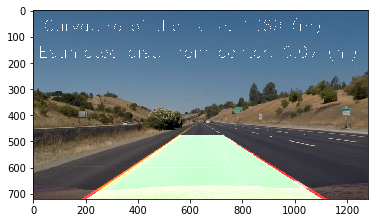

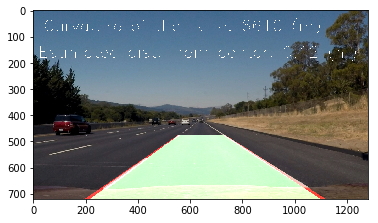

/usr/local/anaconda/anaconda3/envs/clone_tfp36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in int_scalars
  if sys.path[0] == '':


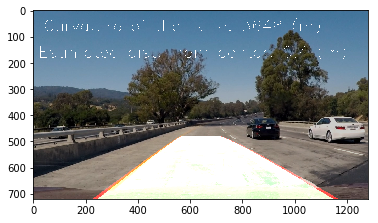

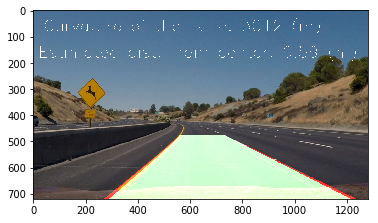

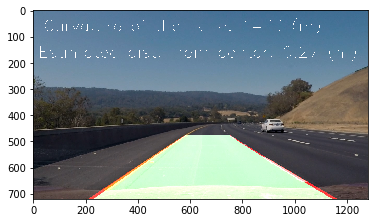

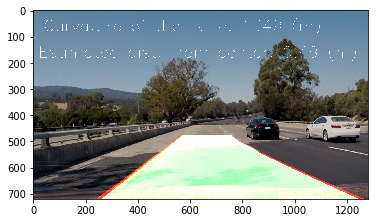

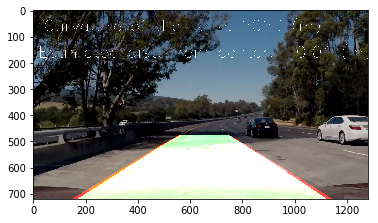

/usr/local/anaconda/anaconda3/envs/clone_tfp36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


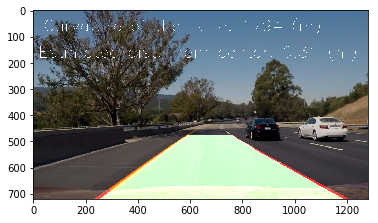

In [67]:


# apply full pipeline to test images
for i in range(8):
    plt.imshow(process_img_pipe(imgs1[i]))
    plt.pause(1)

In [68]:

# 29 . Save video file

from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process1(img):
    return process_img_pipe(img)


yellow_output = 'test1project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('project_video.mp4').subclip(0,5)
#clip2 = VideoFileClip('project_video.mp4')
clip2 = VideoFileClip('project_video.mp4').subclip(40, 48)
yellow_clip = clip2.fl_image(process1)
yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test1v5.mp4
[MoviePy] Writing video test1v5.mp4


  2%|▏         | 22/1136 [00:14<12:05,  1.54it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  3%|▎         | 35/1136 [00:22<11:50,  1.55it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  5%|▌         | 59/1136 [00:38<11:45,  1.53it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  5%|▌         | 60/1136 [00:38<11:37,  1.54it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  5%|▌         | 61/1136 [00:39<11:30,  1.56it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  7%|▋         | 83/1136 [00:53<11:24,  1.54it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  7%|▋         | 84/1136 [00:54<11:19,  1.55it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  7%|▋         | 85/1136 [00:54<11:14,  1.56it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



  8%|▊         | 96/1136 [01:01<11:07,  1.56it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



 21%|██        | 238/1136 [02:50<10:43,  1.39it/s]

expected non-empty vector for x


 56%|█████▋    | 640/1136 [07:43<05:58,  1.38it/s]

expected non-empty vector for x


 57%|█████▋    | 647/1136 [07:47<05:53,  1.38it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



 57%|█████▋    | 651/1136 [07:50<05:50,  1.38it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



 57%|█████▋    | 652/1136 [07:50<05:49,  1.38it/s]

expected non-empty vector for x


 59%|█████▊    | 665/1136 [07:59<05:39,  1.39it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



 60%|█████▉    | 676/1136 [08:07<05:31,  1.39it/s]

expected non-empty vector for x


 61%|██████    | 688/1136 [08:16<05:23,  1.38it/s]

expected non-empty vector for x


 99%|█████████▉| 1126/1136 [13:40<00:07,  1.37it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



 99%|█████████▉| 1127/1136 [13:40<00:06,  1.37it/s]

/io/opencv/modules/imgproc/src/imgwarp.cpp:3002: error: (-215) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function warpPerspective



100%|█████████▉| 1135/1136 [13:47<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test1v5.mp4 

